In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import r2_score
import copy
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [3]:
df = pd.read_csv("df_final_log_transform.csv")
df.head()

,SKU,Fecha,Demanda_Total,Precio_Prom_Venta,Num_Transacciones,Num_Feriados,Num_Dias_Pago,Num_Dias_Promocion,Precio_base,Rotacion_Cod,Target_Demanda_Futura
0,SKU-0001,2025-01-05,48,9.962500,16,0,0,0,10.0,3,109.0
1,SKU-0001,2025-01-19,109,9.852632,38,0,0,0,10.0,3,131.0
2,SKU-0001,2025-02-02,131,9.649057,53,0,5,0,10.0,3,102.0
3,SKU-0001,2025-02-16,102,9.454054,37,0,3,2,10.0,3,126.0
4,SKU-0001,2025-03-02,126,9.289583,48,0,5,0,10.0,3,115.0


FEATURES

In [5]:
FEATURES = [
    'Demanda_Total', 
    'Precio_Prom_Venta', 
    'Num_Transacciones', 
    'Precio_base', 
    'Rotacion_Cod',
    'Num_Feriados',
    'Num_Dias_Pago',
    'Num_Dias_Promocion'
]

TARGET = 'Target_Demanda_Futura'

df['Target_Log'] = np.log1p(df[TARGET])

# Ahora nuestro objetivo de entrenamiento es el LOGARITMO de la demanda, no la demanda cruda.
TARGET_TRAIN = 'Target_Log' 

# Definimos los scalers
scaler_x = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

df_scaled = df.copy()

# Escalar Features (X) - Esto se queda igual
df_scaled[FEATURES] = scaler_x.fit_transform(df[FEATURES])

# --- 🚀 CAMBIO 2: ESCALAR EL TARGET LOGARÍTMICO (Y) ---
# OJO: Estamos escalando 'Target_Log', no 'Target_Demanda_Futura'
df_scaled[TARGET_TRAIN] = scaler_y.fit_transform(df[[TARGET_TRAIN]])

print("Datos escalados (Features normalizadas y Target con Log-Transform).")
print(df_scaled.head())

Datos escalados (Features normalizadas y Target con Log-Transform).
        SKU       Fecha  Demanda_Total  Precio_Prom_Venta  Num_Transacciones  \
0  SKU-0001  2025-01-05       0.222222           0.111687           0.192771   
1  SKU-0001  2025-01-19       0.504630           0.110456           0.457831   
2  SKU-0001  2025-02-02       0.606481           0.108173           0.638554   
3  SKU-0001  2025-02-16       0.472222           0.105987           0.445783   
4  SKU-0001  2025-03-02       0.583333           0.104143           0.578313   

   Num_Feriados  Num_Dias_Pago  Num_Dias_Promocion  Precio_base  Rotacion_Cod  \
0           0.0       0.000000               0.000     0.101466           1.0   
1           0.0       0.000000               0.000     0.101466           1.0   
2           0.0       0.357143               0.000     0.101466           1.0   
3           0.0       0.214286               0.125     0.101466           1.0   
4           0.0       0.357143               0

In [6]:
#Creando secuencias 3D (ventanas de tiempo)
# Usaremos 5 quincenas pasadas para predecir la 6ta.
TIME_STEPS = 5 

def create_sequences(data, features, target, time_steps):
    X_seq, Y_seq = [], []
    
   
    for sku, group in data.groupby('SKU'):
        
        feature_data = group[features].values
        target_data = group[target].values
        
       
        for i in range(len(group) - time_steps):
            
            X_sample = feature_data[i : (i + time_steps)]
           
            Y_sample = target_data[i + time_steps]
            
            X_seq.append(X_sample)
            Y_seq.append(Y_sample)
            
    return np.array(X_seq), np.array(Y_seq)

X, Y = create_sequences(df_scaled, FEATURES, TARGET_TRAIN, TIME_STEPS)

In [7]:
#print("Dividiendo en sets de Entrenamiento, Validación y Prueba...")

total_samples = len(X)
train_size = int(total_samples * 0.70)
val_size = int(total_samples * 0.15)
# El resto es 'test_size'

# División secuencial
X_train, Y_train = X[0:train_size], Y[0:train_size]
X_val, Y_val = X[train_size : train_size + val_size], Y[train_size : train_size + val_size]
X_test, Y_test = X[train_size + val_size :], Y[train_size + val_size :]

print("\n--- ¡Preparación de Datos Completada! ---")
print("Formatos (shapes) de los datos listos para el GRU:")
print(f"X_train (Muestras, Pasos_Tiempo, Features): {X_train.shape}")
print(f"Y_train (Muestras):                       {Y_train.shape}")
print(f"X_val:                                    {X_val.shape}")
print(f"Y_val:                                    {Y_val.shape}")
print(f"X_test:                                   {X_test.shape}")
print(f"Y_test:                                   {Y_test.shape}")

print("\nScalers 'scaler_x' y 'scaler_y' están listos en memoria.")


--- ¡Preparación de Datos Completada! ---
Formatos (shapes) de los datos listos para el GRU:
X_train (Muestras, Pasos_Tiempo, Features): (13390, 5, 8)
Y_train (Muestras):                       (13390,)
X_val:                                    (2869, 5, 8)
Y_val:                                    (2869,)
X_test:                                   (2870, 5, 8)
Y_test:                                   (2870,)

Scalers 'scaler_x' y 'scaler_y' están listos en memoria.


In [8]:
X_train_tensor = torch.tensor(X_train).float()
Y_train_tensor = torch.tensor(Y_train).float()

X_val_tensor = torch.tensor(X_val).float()
Y_val_tensor = torch.tensor(Y_val).float()

X_test_tensor = torch.tensor(X_test).float()
Y_test_tensor = torch.tensor(Y_test).float()

Y_train_tensor = Y_train_tensor.unsqueeze(1)
Y_val_tensor = Y_val_tensor.unsqueeze(1)
Y_test_tensor = Y_test_tensor.unsqueeze(1)

batch_size = 64

In [9]:
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(X_val_tensor, Y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"DataLoaders listos. Tamaño del lote (batch_size): {batch_size}")

DataLoaders listos. Tamaño del lote (batch_size): 64


In [10]:
import random

SEED = 42 # Empezaremos con 42

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(SEED)
print(f"Semilla aleatoria fijada en: {SEED}")

Semilla aleatoria fijada en: 42


In [11]:
class GRUModel(nn.Module):
    
    # Añadimos 'dropout_prob'
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob):
        super(GRUModel, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_size, 
                          hidden_size, 
                          num_layers, 
                          batch_first=True,
                          dropout=dropout_prob)
        
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out

In [15]:
#Hiperparametros
INPUT_SIZE = X_train_tensor.shape[2] 
OUTPUT_SIZE = 1 
HIDDEN_SIZE = 128
NUM_LAYERS = 3
LEARNING_RATE = 0.0003
NUM_EPOCHS = 500 
CLIP_VALUE = 1.0 # (Para Gradient Clipping)
DROPOUT_PROB = 0.5 # (50% de apagado aleatorio)
PATIENCE = 20 

MODEL_PATH = f"GRU_CAMPEON_seed{SEED}_lr{LEARNING_RATE}.pth"

model = GRUModel(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE, DROPOUT_PROB)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(f"Iniciando entrenamiento con {NUM_EPOCHS} épocas (Paciencia={PATIENCE})...")

history_loss = []
history_val_loss = []
history_r2_score = [] 

best_val_loss = float('inf') 
patience_counter = 0
best_model_weights = None 

for epoch in range(NUM_EPOCHS):
    
    #Entrenamiento
    model.train()
    epoch_train_loss = 0.0
    for batch_X, batch_Y in train_loader:
        outputs = model(batch_X)
        loss = criterion(outputs, batch_Y)
        optimizer.zero_grad()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_VALUE)

        optimizer.step()
        epoch_train_loss += loss.item()
        
    avg_train_loss = epoch_train_loss / len(train_loader)
    history_loss.append(avg_train_loss)

    model.eval()
    epoch_val_loss = 0.0

    all_y_val = []
    all_outputs_val = []
    
    with torch.no_grad():
        for batch_X_val, batch_Y_val in val_loader:
            outputs_val = model(batch_X_val)
            loss_val = criterion(outputs_val, batch_Y_val)
            epoch_val_loss += loss_val.item()
            
            # Guardamos los tensores (en CPU) para el R²
            all_y_val.append(batch_Y_val.cpu())
            all_outputs_val.append(outputs_val.cpu())
            
    avg_val_loss = epoch_val_loss / len(val_loader)
    history_val_loss.append(avg_val_loss)
    
    # Concatenamos todos los lotes de validación
    all_y_val = torch.cat(all_y_val).numpy()
    all_outputs_val = torch.cat(all_outputs_val).numpy()
    
    # Calculamos R²
    r2 = r2_score(all_y_val, all_outputs_val)
    history_r2_score.append(r2)
    
    # Imprimir el progreso
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Loss(Train): {avg_train_loss:.5f}, Loss(Val): {avg_val_loss:.5f}, R² (Val): {r2:.4f}")


    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0 
        best_model_weights = copy.deepcopy(model.state_dict())
        print(f"   -> Mejorado. Guardando modelo...")
    else:
        patience_counter += 1
        
    if patience_counter >= PATIENCE:
        print(f"\n¡Early Stopping activado en la época {epoch+1}!")
        print(f"La pérdida de validación no mejoró por {PATIENCE} épocas.")
        break 

if best_model_weights:
    print("Cargando pesos del mejor modelo guardado.")
    model.load_state_dict(best_model_weights)

print("Entrenamiento completado.")

#GUARDAR EL MEJOR MODELO
if best_model_weights:
    torch.save(best_model_weights, MODEL_PATH)
else:
    print("\nError: No se guardó ningún modelo.")

Iniciando entrenamiento con 500 épocas (Paciencia=20)...
Epoch [1/500], Loss(Train): 0.02537, Loss(Val): 0.02451, R² (Val): 0.0378
   -> Mejorado. Guardando modelo...
Epoch [2/500], Loss(Train): 0.02250, Loss(Val): 0.02404, R² (Val): 0.0577
   -> Mejorado. Guardando modelo...
Epoch [3/500], Loss(Train): 0.02152, Loss(Val): 0.02480, R² (Val): 0.0271
Epoch [4/500], Loss(Train): 0.02109, Loss(Val): 0.02235, R² (Val): 0.1201
   -> Mejorado. Guardando modelo...
Epoch [5/500], Loss(Train): 0.02080, Loss(Val): 0.02223, R² (Val): 0.1238
   -> Mejorado. Guardando modelo...
Epoch [6/500], Loss(Train): 0.02056, Loss(Val): 0.02198, R² (Val): 0.1341
   -> Mejorado. Guardando modelo...
Epoch [7/500], Loss(Train): 0.02055, Loss(Val): 0.02203, R² (Val): 0.1325
Epoch [8/500], Loss(Train): 0.02049, Loss(Val): 0.02197, R² (Val): 0.1349
   -> Mejorado. Guardando modelo...
Epoch [9/500], Loss(Train): 0.02051, Loss(Val): 0.02182, R² (Val): 0.1405
   -> Mejorado. Guardando modelo...
Epoch [10/500], Loss(Trai

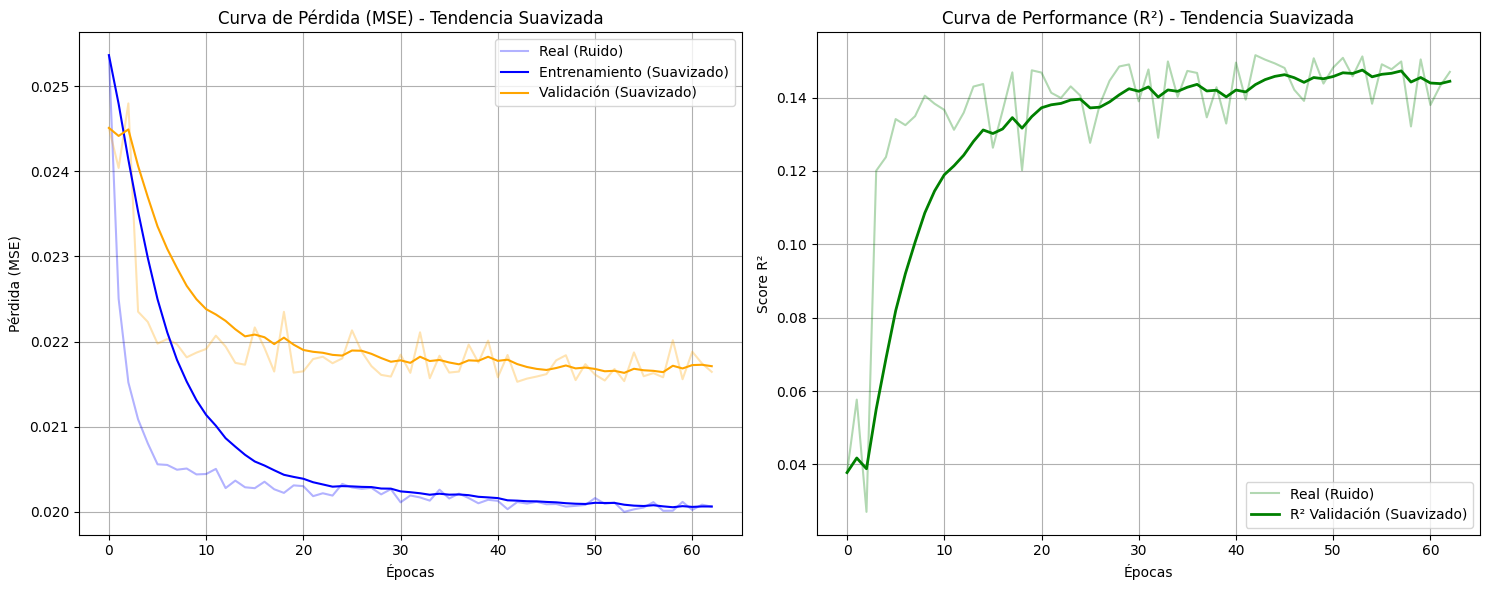

In [16]:
# --- Función para Suavizar Curvas (Exponential Moving Average) ---
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.figure(figsize=(15, 6))

# --- Gráfico 1: Curva de Pérdida (MSE) ---
plt.subplot(1, 2, 1) 

# 1. Graficamos la línea real (tenue) para ver el ruido real
plt.plot(history_loss, alpha=0.3, color='blue', label='Real (Ruido)')
plt.plot(history_val_loss, alpha=0.3, color='orange')

# 2. Graficamos la línea SUAVIZADA (fuerte) para ver la tendencia
plt.plot(smooth_curve(history_loss), color='blue', label='Entrenamiento (Suavizado)')
plt.plot(smooth_curve(history_val_loss), color='orange', label='Validación (Suavizado)')

plt.title('Curva de Pérdida (MSE) - Tendencia Suavizada')
plt.ylabel('Pérdida (MSE)')
plt.xlabel('Épocas')
plt.legend(loc='upper right')
plt.grid(True)

# --- Gráfico 2: Curva de Performance (R²) ---
plt.subplot(1, 2, 2) 
# Real (Tenue)
plt.plot(history_r2_score, alpha=0.3, color='green', label='Real (Ruido)')
# Suavizada (Fuerte)
plt.plot(smooth_curve(history_r2_score), color='green', linewidth=2, label='R² Validación (Suavizado)')

plt.title('Curva de Performance (R²) - Tendencia Suavizada')
plt.ylabel('Score R²')
plt.xlabel('Épocas')
plt.legend(loc='lower right')
plt.grid(True)

plt.tight_layout() 
plt.show()


Métricas Finales del Modelo
  Score R² (Test):     0.1719
  Error (MAE Test):    2.5698 (Unidades de Demanda)
  Error (RMSE Test):   3.7439 (Unidades de Demanda)

El MAE significa que, en promedio, las predicciones del modelo
se desvían en 2.57 unidades de la demanda real.


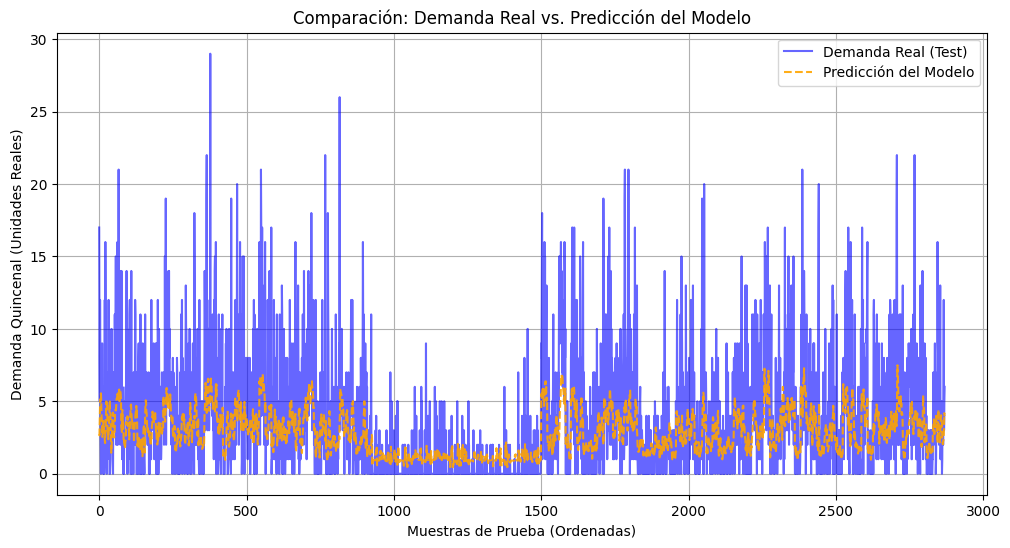

In [17]:
model.eval() 

all_y_test = []
all_outputs_test = []

with torch.no_grad(): 
    for batch_X_test, batch_Y_test in test_loader:
        outputs_test = model(batch_X_test)
        all_y_test.append(batch_Y_test.cpu())
        all_outputs_test.append(outputs_test.cpu())

all_y_test = torch.cat(all_y_test).numpy()
all_outputs_test = torch.cat(all_outputs_test).numpy()

# --- 🚀 CORRECCIÓN CRÍTICA: INVERTIR SCALER Y LOGARITMO ---

# 1. Deshacer el Escalado (Esto nos devuelve valores en escala Logarítmica)
y_test_log = scaler_y.inverse_transform(all_y_test)
y_pred_log = scaler_y.inverse_transform(all_outputs_test)

# 2. Deshacer el Logaritmo (np.expm1 es la inversa de np.log1p)
# Esto nos devuelve las UNIDADES REALES de demanda
y_test_real = np.expm1(y_test_log)
y_pred_real = np.expm1(y_pred_log)

# -----------------------------------------------------------

# Calcular métricas con los valores reales
test_mse = mean_squared_error(y_test_real, y_pred_real)
test_rmse = np.sqrt(test_mse) 
test_mae = mean_absolute_error(y_test_real, y_pred_real)
test_r2 = r2_score(y_test_real, y_pred_real)

print("\nMétricas Finales del Modelo")
print(f"  Score R² (Test):     {test_r2:.4f}")
print(f"  Error (MAE Test):    {test_mae:.4f} (Unidades de Demanda)")
print(f"  Error (RMSE Test):   {test_rmse:.4f} (Unidades de Demanda)")
print("\nEl MAE significa que, en promedio, las predicciones del modelo")
print(f"se desvían en {test_mae:.2f} unidades de la demanda real.")

# Gráfica de Comparación
plt.figure(figsize=(12, 6))
plt.plot(y_test_real, label='Demanda Real (Test)', color='blue', alpha=0.6)
plt.plot(y_pred_real, label='Predicción del Modelo', color='orange', linestyle='--', alpha=0.9)
plt.title('Comparación: Demanda Real vs. Predicción del Modelo')
plt.ylabel('Demanda Quincenal (Unidades Reales)')
plt.xlabel('Muestras de Prueba (Ordenadas)')
plt.legend()
plt.grid(True)
plt.show()

LLAMAR AL MODELO

In [38]:
import os

INPUT_SIZE = 8   # Tus 8 features
HIDDEN_SIZE = 128
NUM_LAYERS = 3
OUTPUT_SIZE = 1
DROPOUT_PROB = 0.5

# 2. Nombre del archivo a cargar
# Asegúrate de que este archivo exista en la carpeta (mira tu explorador de archivos a la izquierda)
MODEL_PATH = "GRU_CAMPEON_seed42_lr0.0003.pth" 

if os.path.exists(MODEL_PATH):
    print(f"Cargando modelo desde: {MODEL_PATH} ...")

    # 3. Instanciar la arquitectura (El esqueleto)
    model_cargado = GRUModel(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE, DROPOUT_PROB)

    # 4. Cargar los pesos (El cerebro)
    model_cargado.load_state_dict(torch.load(MODEL_PATH))

    # 5. Poner en modo evaluación (Apaga Dropout)
    model_cargado.eval()

    print("Modelo cargado exitosamente en la variable 'model_cargado'")
    print("Ya puedes usar la siguiente celda para probar SKUs.")
else:
    print(f"ERROR: No se encontró el archivo {MODEL_PATH}")
    print("Verifica que hayas corrido el entrenamiento y guardado el archivo.")

Cargando modelo desde: GRU_CAMPEON_seed42_lr0.0003.pth ...
Modelo cargado exitosamente en la variable 'model_cargado'
Ya puedes usar la siguiente celda para probar SKUs.


C:\Users\agabr\AppData\Local\Temp\ipykernel_32168\3903898681.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_cargado.load_state_dict(torch.load(MODEL_PATH))


In [36]:
sku_a_probar = 'SKU-0002'

TIME_STEPS = 5 

df_sku = df[df['SKU'] == sku_a_probar]

if len(df_sku) < TIME_STEPS:
    print(f"Error: El SKU {sku_a_probar} no tiene suficientes datos históricos (mínimo {TIME_STEPS} quincenas).")
    print("Prueba con otro SKU.")

else:
    # 1. Obtener las últimas 5 quincenas (X)
    ultimas_quincenas = df_sku.tail(TIME_STEPS)
    
    # 2. Preparar los datos (Escalar)
    features_reales = ultimas_quincenas[FEATURES].values
    features_scaled = scaler_x.transform(features_reales)

    input_tensor = torch.tensor(features_scaled[np.newaxis, :, :]).float()

    with torch.no_grad():
        pred_log_scaled = model_cargado(input_tensor)

    pred_log = scaler_y.inverse_transform(pred_log_scaled.numpy())

    pred_unidades = np.expm1(pred_log)

    demanda_real_anterior = ultimas_quincenas.iloc[-1]['Demanda_Total']

    # --- RESULTADO ---
    print(f"\nREPORTE DE PREDICCIÓN: {sku_a_probar}")
    print("-" * 40)
    print(f"Demanda Real (Última Quincena):   {demanda_real_anterior:.0f} unidades")
    print(f"Pronóstico (Siguiente Quincena):  {pred_unidades[0][0]:.0f} unidades")
    print("-" * 40)
    
    if pred_unidades[0][0] > demanda_real_anterior:
        print("Tendencia: SE ESPERA UN AUMENTO en la demanda.")
    else:
        print("Tendencia: SE ESPERA UNA BAJA en la demanda.")


REPORTE DE PREDICCIÓN: SKU-0002
----------------------------------------
Demanda Real (Última Quincena):   172 unidades
Pronóstico (Siguiente Quincena):  145 unidades
----------------------------------------
Tendencia: SE ESPERA UNA BAJA en la demanda.


c:\Users\agabr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


PRUEBA DE OUTPUT

In [ ]:
sku_a_probar = 'SKU-0002'
TIME_STEPS = 5 

START_INDEX = 0  

df['Fecha'] = pd.to_datetime(df['Fecha'])

df_sku = df[df['SKU'] == sku_a_probar].sort_values('Fecha')

if len(df_sku) < TIME_STEPS + 1:
    print(f"Error: El SKU {sku_a_probar} no tiene suficientes datos.")
else:

    ventana_input = df_sku.iloc[START_INDEX : START_INDEX + TIME_STEPS]

    fila_target_real = df_sku.iloc[START_INDEX + TIME_STEPS]

    features_reales = ventana_input[FEATURES].values
    features_scaled = scaler_x.transform(features_reales)
    input_tensor = torch.tensor(features_scaled[np.newaxis, :, :]).float()

    with torch.no_grad():
        pred_log_scaled = model_cargado(input_tensor)

    pred_log = scaler_y.inverse_transform(pred_log_scaled.numpy())
    pred_unidades = np.expm1(pred_log)[0][0]

    demanda_real_anterior = ventana_input.iloc[-1]['Demanda_Total']

    fecha_prediccion = fila_target_real['Fecha'].date()

    print(f"\nREPORTE DE PREDICCIÓN: {sku_a_probar} (Fecha: {fecha_prediccion})")
    print("-" * 40)
    print(f"Demanda Real (Última Quincena):   {demanda_real_anterior:.0f} unidades")
    print(f"Pronóstico (Siguiente Quincena):  {pred_unidades:.0f} unidades")
    print("-" * 40)
    
    if pred_unidades > demanda_real_anterior:
        print("Tendencia: 📈 SE ESPERA UN AUMENTO en la demanda.")
    elif pred_unidades < demanda_real_anterior:
        print("Tendencia: 📉 SE ESPERA UNA BAJA en la demanda.")
    else:
        print("Tendencia: ➡️ SE ESPERA QUE SE MANTENGA.")

    demanda_que_ocurrio = fila_target_real['Demanda_Total']
    print(f"\n(Validación Interna: La demanda real que ocurrió fue {demanda_que_ocurrio:.0f} unidades)")


REPORTE DE PREDICCIÓN: SKU-0002 (Fecha: 2025-03-16)
----------------------------------------
Demanda Real (Última Quincena):   175 unidades
Pronóstico (Siguiente Quincena):  102 unidades
----------------------------------------
Tendencia: 📉 SE ESPERA UNA BAJA en la demanda.

(Validación Interna: La demanda real que ocurrió fue 114 unidades)


c:\Users\agabr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
